In [1]:
"""************************************
Installing the Hugging Face Transformers library
***************************************"""
!pip3 install transformers  
"""************************************
Installing the Hugging Face Transformers library
***************************************"""
!pip3 install torch       

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import math  # Provides mathematical functions and constants.
import os  # Provides functions for interacting with the operating system.
import re  # Provides support for regular expressions.
import gensim  # Provides tools for topic modeling and document similarity.
import gensim.downloader as api  # Provides access to pre-trained word embeddings.
import nltk  # Provides natural language processing tools and resources.
import numpy as np  # Provides support for numerical operations.
import pandas as pd  # Provides data manipulation and analysis tools.
from nltk.corpus import stopwords  # Provides a list of common stopwords.
from sklearn import metrics  # Provides evaluation metrics for machine learning models.
from sklearn.metrics.pairwise import cosine_similarity  # Computes cosine similarity between vectors.
from sklearn.metrics import accuracy_score   # Computes accuracy result.
import matplotlib.pyplot as plt  # Provides plotting functionalities.
import seaborn as sns  # Provides additional plotting styles and options.
import torch  # Provides tools for deep learning using PyTorch.
from nltk.tokenize import word_tokenize  # Tokenizes words from text.
from transformers import BertForQuestionAnswering, BertTokenizer  # Provides tools for question answering with BERT.
pd.set_option('display.max_colwidth', 1)  # Sets an option for displaying data in pandas.


In [10]:
"""************************************
Reading in the dataset from three different files
***************************************"""

df1 = pd.read_csv('C:/Users/Amir Hassan/Desktop/Python/BERT_Model/dataset/S08_question_answer_pairs.txt', sep='\t')
df2 = pd.read_csv('C:/Users/Amir Hassan/Desktop/Python/BERT_Model/dataset/S09_question_answer_pairs.txt', sep='\t')
df3 = pd.read_csv('C:/Users/Amir Hassan/Desktop/Python/BERT_Model/dataset/S10_question_answer_pairs.txt', sep='\t', encoding = 'ISO-8859-1')


"""************************************
Concatenating the three DataFrames into a single DataFrame named as df and showing it down
***************************************"""

frames = [df1, df2, df3]
df = pd.concat(frames)


"""************************************
Displaying the concatenated DataFrame.
***************************************"""

df

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of the United States?,yes,easy,easy,S08_set3_a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of the United States?,Yes.,easy,easy,S08_set3_a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1863?,yes,easy,medium,S08_set3_a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1863?,Yes.,easy,easy,S08_set3_a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,S08_set3_a4
...,...,...,...,...,...,...
1453,Zebra,What areas do the Grevy's Zebras inhabit?,NaN,hard,NaN,S10_set1_a9
1454,Zebra,Which species of zebra is known as the common zebra?,"Plains Zebra (Equus quagga, formerly Equus burchelli)",hard,medium,S10_set1_a9
1455,Zebra,Which species of zebra is known as the common zebra?,Plains Zebra,hard,medium,S10_set1_a9
1456,Zebra,At what age can a zebra breed?,five or six,hard,medium,S10_set1_a9


In [11]:
"""************************************
Printing a concise summary of the DataFrame df
***************************************"""

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3998 entries, 0 to 1457
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ArticleTitle              3998 non-null   object
 1   Question                  3961 non-null   object
 2   Answer                    3420 non-null   object
 3   DifficultyFromQuestioner  3043 non-null   object
 4   DifficultyFromAnswerer    3418 non-null   object
 5   ArticleFile               3996 non-null   object
dtypes: object(6)
memory usage: 218.6+ KB


In [12]:
"""************************************
This(getArticleText) function reads the content of a text file specified by the input filename and directory path, 
handling UnicodeDecodeError by attempting to open the file with a different encoding (ISO-8859-1) if necessary, 
and then returns the text content of the file.
***************************************"""

def getArticleText(file):
    # Define the file path using the input filename and directory path
    fpath = 'C:/Users/Amir Hassan/Desktop/Python/BERT_Model/dataset/text_data/' + file + '.txt.clean'

    try:
        # Try opening the file in 'r' (read) mode
        f = open(fpath, 'r')
        # Read the content of the file
        text = f.read()
    except UnicodeDecodeError:
        # If a UnicodeDecodeError occurs, try opening the file with a different encoding (ISO-8859-1)
        f = open(fpath, 'r', encoding='ISO-8859-1')
        # Read the content of the file
        text = f.read()

    # Close the file
    f.close()

    # Return the text content of the file
    return text


In [13]:
"""************************************
Drop rows with NaN values in the 'ArticleFile' and 'Answer' columns
***************************************"""

df = df.dropna(subset=['ArticleFile'])
df = df.dropna(subset=['Answer'])

 
"""************************************
Apply the getArticleText function to the 'ArticleFile' column and store the result in a new 'ArticleText' column
***************************************"""

df['ArticleText'] = df['ArticleFile'].apply(lambda x: getArticleText(x))


"""************************************
Replace newline characters with a dot and space in the 'ArticleText' column
***************************************"""

df['ArticleText'] = df['ArticleText'].apply(lambda x: re.sub(r'(\n)+', '. ', x))


"""************************************
Drop specified columns from the DataFrame
***************************************"""

df = df.drop(['DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleFile'], axis='columns')

"""************************************
Displaying the concatenated DataFrame.
***************************************"""
df

ArticleTitle  \
0     Abraham_Lincoln   
1     Abraham_Lincoln   
2     Abraham_Lincoln   
3     Abraham_Lincoln   
4     Abraham_Lincoln   
...               ...   
1452  Zebra             
1454  Zebra             
1455  Zebra             
1456  Zebra             
1457  Zebra             

                                                               Question  \
0     Was Abraham Lincoln the sixteenth President of the United States?   
1     Was Abraham Lincoln the sixteenth President of the United States?   
2     Did Lincoln sign the National Banking Act of 1863?                  
3     Did Lincoln sign the National Banking Act of 1863?                  
4     Did his mother die of pneumonia?                                    
...                                ...                                    
1452  What areas do the Grevy's Zebras inhabit?                           
1454  Which species of zebra is known as the common zebra?                
1455  Which species of zebra is known as the common zebra?                
1456  At what age can a zebra breed?                                      
1457  At what age can a zebra breed?                                      

                                                     Answer  \
0     yes                                                     
1     Yes.                                                    
2     yes                                                     
3     Yes.                                                    
4     no                                                      
...   ..                                                      
1452  semi-arid grasslands of Ethiopia and northern Kenya     
1454  Plains Zebra (Equus quagga, formerly Equus burchelli)   
1455  Plains Zebra                                            
1456  five or six                                             
1457  5 or 6                                                  

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [14]:
"""************************************
Displaying the first few rows of the DataFrame df.
***************************************"""

df.head()

ArticleTitle  \
0  Abraham_Lincoln   
1  Abraham_Lincoln   
2  Abraham_Lincoln   
3  Abraham_Lincoln   
4  Abraham_Lincoln   

                                                            Question Answer  \
0  Was Abraham Lincoln the sixteenth President of the United States?  yes     
1  Was Abraham Lincoln the sixteenth President of the United States?  Yes.    
2  Did Lincoln sign the National Banking Act of 1863?                 yes     
3  Did Lincoln sign the National Banking Act of 1863?                 Yes.    
4  Did his mother die of pneumonia?                                   no      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [15]:
X=list(df['Question'])

In [16]:
y=list(df['ArticleTitle'])

In [17]:
y

['Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Abraham_Lincoln',
 'Amedeo_Avogadro',
 'Amedeo_Avogadro',
 'Amedeo_Avogadro',
 'Amedeo_Avogadro',
 'Amedeo_Avogadro',


In [18]:
y=list(pd.get_dummies(y,drop_first=True)['Canada'])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [20]:
X_train

['Was Faraday born in England?',
 "Do drums consist of at least one membrane, called a drumhead or drum skin, that is stretched over a shell and struck, either directly with parts of a player's body, or with some sort of implement such as a drumstick, to produce sound?",
 'What traps a layer of air, and keeps them dry and warm under water?',
 'Do worker ants have wings?',
 'Are the most active in Damascus and Cairo?',
 'How many years after Cleveland left office did the U.S. win the Spanish-American War?',
 'Has the design of drums changed recently?',
 "Is it the world 's second largest country by total area?",
 'Did lincoln have 18 months of schooling?',
 'Of whose continual poor health was the cause never precisely determined?',
 'Who founded Montevideo?',
 'When did classical Chinese literature begin?',
 'Had Monroe racked up many debts during his years of public life ?',
 'In what year did East Timor secede from Indonesia?',
 'What was founded by the Spanish in the early 18th centu

In [21]:
"""************************************
Returning the dimensions of the DataFrame df including (number of rows, number of columns).
***************************************"""

df.shape

(3418, 4)

In [22]:
"""************************************
Returning the data types of each column in the DataFrame df.
***************************************"""

df.dtypes

ArticleTitle    object
Question        object
Answer          object
ArticleText     object
dtype: object

In [23]:
"""************************************
Generating descriptive statistics of the DataFrame's numerical columns df.
***************************************"""

df.describe()

ArticleTitle                           Question Answer  \
count   3418             3418                               3418    
unique  106              2202                               1826    
top     Amedeo_Avogadro  Where is Uruguay's oldest church?  Yes     
freq    87               4                                  492     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [24]:
"""************************************
Returning a list of column names in the DataFrame df.
***************************************"""

list(df.columns)

['ArticleTitle', 'Question', 'Answer', 'ArticleText']

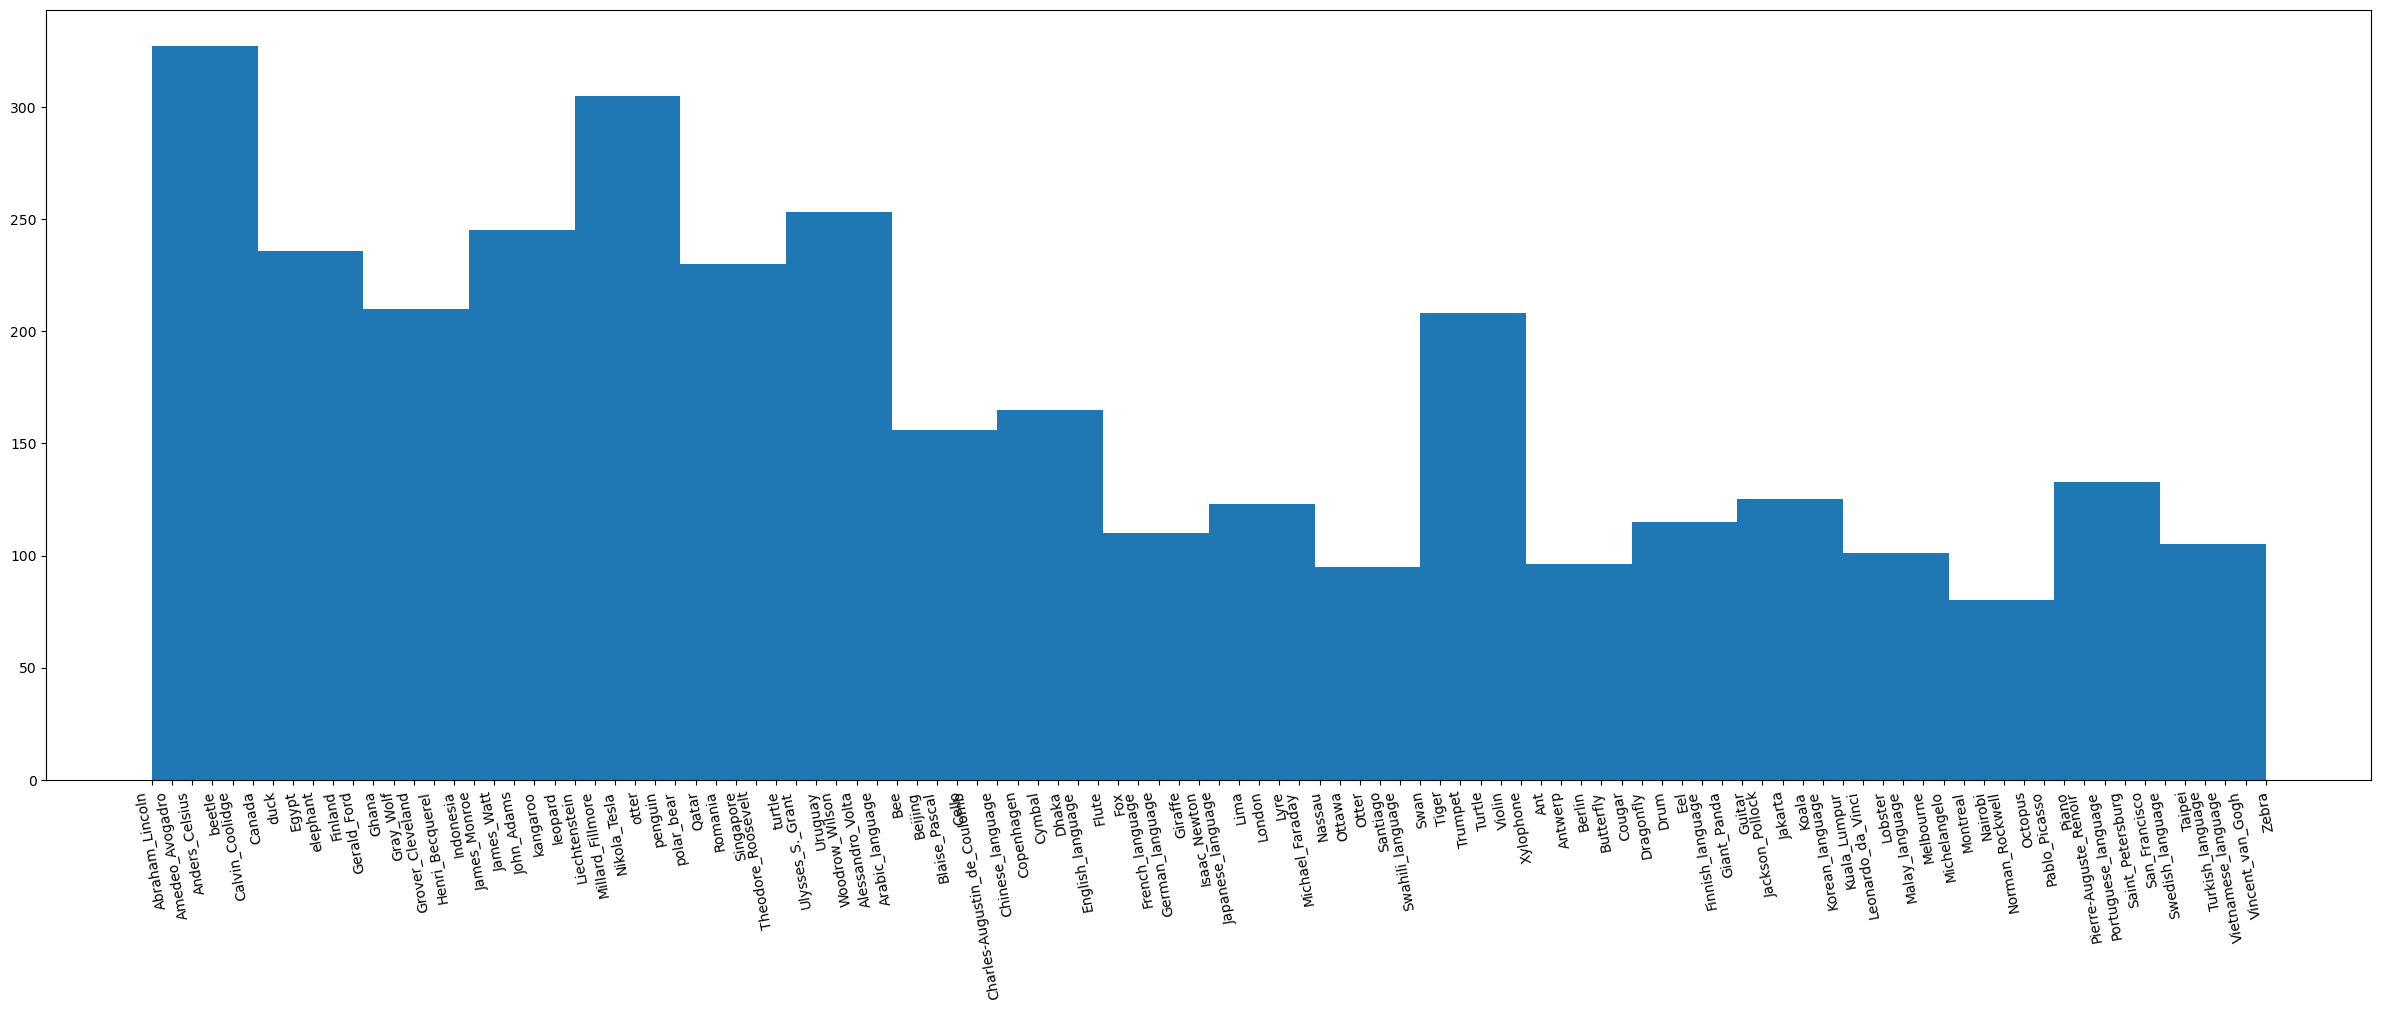

In [25]:
"""************************************
This code sets the size of the figure to be displayed to a width of 30 inches and a height of 10 inches. 
It then plots a histogram of the values in the 'ArticleTitle' column of the DataFrame df, 
with the data divided into 20 bins. Additionally, it rotates the x-axis labels by 100 degrees to improve readability. 
Finally, it displays the histogram using plt.show().

Note: Due to large text, It is not showing clearly. To see clear visibility, only possible from dataframe df.
***************************************"""

plt.figure(figsize=(30, 10))  # Set the size of the figure (width=30 inches, height=10 inches)
plt.hist(df['ArticleTitle'], bins=20)
plt.xticks(rotation=100)  # Rotate x-axis labels by 100 degrees
plt.show()


In [26]:
"""************************************
cleanQuestion() function cleans the input text by converting it to lowercase, removing non-alphanumeric characters, 
and splitting it into words, then returns the cleaned text as a single string.
***************************************"""

def cleanQuestion(text):
  text = str(text)
  text = text.lower()
  words = re.sub(r'[^\w\s]', '', text).split()
  return " ".join([word for word in words])


"""************************************
cleanAnswer() function cleans the input text by converting it to lowercase, removing non-alphanumeric characters, 
and splitting it into words, then returns the cleaned text as a single string.
***************************************"""

def cleanAnswer(text):
  text = str(text)
  text = text.lower()
  words = re.sub(r'[^\w\s]', '', text).split()
  return " ".join([word for word in words])


"""************************************
cleanText() function cleans the input text by converting it to lowercase, removing non-alphanumeric characters, 
including periods and question marks, and splitting it into words. Then it returns the cleaned text as a single string.
***************************************"""

def cleanText(text):
  text = str(text)
  text = text.lower()
  words = re.sub(r'[^\w\s\.\?]', '', text).split()
  return " ".join([word for word in words])

In [27]:
"""************************************
Cleans the 'Question' column using cleanQuestion function
***************************************"""

df['Question'] = df['Question'].apply(lambda x: cleanQuestion(x))


"""************************************
Cleans the 'Answer' column using cleanAnswer function.
***************************************"""

df['Answer'] = df['Answer'].apply(lambda x: cleanAnswer(x))


"""************************************
Cleans the 'ArticleText' column using cleanText function.
***************************************"""

df['ArticleText'] = df['ArticleText'].apply(lambda x: cleanText(x))


"""************************************
Displaying the modified DataFrame.
Note:  I have explained these methods in report in detail. 
***************************************"""

df

ArticleTitle  \
0     Abraham_Lincoln   
1     Abraham_Lincoln   
2     Abraham_Lincoln   
3     Abraham_Lincoln   
4     Abraham_Lincoln   
...               ...   
1452  Zebra             
1454  Zebra             
1455  Zebra             
1456  Zebra             
1457  Zebra             

                                                              Question  \
0     was abraham lincoln the sixteenth president of the united states   
1     was abraham lincoln the sixteenth president of the united states   
2     did lincoln sign the national banking act of 1863                  
3     did lincoln sign the national banking act of 1863                  
4     did his mother die of pneumonia                                    
...                               ...                                    
1452  what areas do the grevys zebras inhabit                            
1454  which species of zebra is known as the common zebra                
1455  which species of zebra is known as the common zebra                
1456  at what age can a zebra breed                                      
1457  at what age can a zebra breed                                      

                                                  Answer  \
0     yes                                                  
1     yes                                                  
2     yes                                                  
3     yes                                                  
4     no                                                   
...   ..                                                   
1452  semiarid grasslands of ethiopia and northern kenya   
1454  plains zebra equus quagga formerly equus burchelli   
1455  plains zebra                                         
1456  five or six                                          
1457  5 or 6                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [28]:
"""************************************
Joining all questions in the DataFrame into a single string.
***************************************"""

allQuestion = '. '.join(list(df['Question']))


"""************************************
Joining all answers in the DataFrame into a single string.
***************************************"""

allAnswer = '. '.join(list(df['Answer']))


"""************************************
Joining all article texts in the DataFrame into a single string.
***************************************"""

allContext = '. '.join(list(df['ArticleText']))


"""************************************
Concatenating all questions, answers, and article texts into a single string.
***************************************"""

text = allQuestion + allAnswer + allContext


## **Word2Vec**

In [29]:
"""************************************
Below code processes the DataFrame to extract and organize the text data into a format 
suitable for further analysis or modeling tasks. Further each lines is described below. 
***************************************"""

dataset = []  # Initialize an empty list to store the processed data
title = ""    # Initialize an empty string for the title

# Iterate through the DataFrame in steps of 2
for i in range(0, len(df), 2):
    this_title = df.iloc[i]['ArticleTitle']

    # Check if the title has changed
    if this_title != title:
        title = this_title
        text = df.iloc[i]['ArticleText']
        
        # Split the article text into sentences
        splitted = text.split(sep='.')
        
        # Iterate through the sentences
        for j in range(len(splitted)):
            text = splitted[j]
            
            # Check if the sentence is not empty
            if text != '':
                words = text.split()
                dataset.append(words)

    # Append the question and answer as separate lists of words
    dataset.append(df.iloc[i]['Question'].split())
    dataset.append(df.iloc[i]['Answer'].split())


In [30]:
"""************************************
Using the gensim library to train a Word2Vec model on a dataset (dataset)
***************************************"""

model_wv = gensim.models.Word2Vec(dataset, vector_size=100, window=8, min_count=1, sg=0, workers=8)

In [31]:
"""************************************
Training the Word2Vec model (model_wv) for additional epochs using the provided dataset
***************************************"""

model_wv.train(dataset, total_examples=len(dataset), compute_loss=True, epochs=50)

(24676535, 31147950)

In [32]:
"""************************************
get_embedding() function computes the average word embedding vector for the words in the input sentence using a
pre-trained word embedding model(model_wv). If a word is not found in the model's vocabulary, it is skipped.
If none of the words have embeddings, it returns a list of zeros. Otherwise, it returns the average embedding vector.
***************************************"""

def get_embedding(sentence):
  pos_sum = [0.0 for i in range(100)]
  num = 0
  words = sentence.split()
  for i in words:
    try:
      embed = model_wv.wv[i]
    except:
      continue
    else:
      pos_sum += embed
      num +=1
  if(num==0):
    return pos_sum
  else:
    pos_sum /= num
    return pos_sum


"""************************************
get_answer() function determines the most relevant answer paragraph to the input question by computing the 
distance between the embeddings of the question and each answer paragraph and selecting the answer paragraph 
with the smallest distance.
***************************************"""

def get_answer(question, answer_para):
  question_embedding = get_embedding(rem_stop(question))
  min_distance = math.inf
  answer = 0
  for i in range(len(answer_para)):
    answer_embedding = get_embedding(rem_stop(answer_para[i]))
    distance = np.linalg.norm(question_embedding-answer_embedding)
    if (distance < min_distance):
      answer = i
      # print(answer)
      min_distance = distance
  return answer_para[answer]


"""************************************
rem_stop() function removes stopwords from the input sentence and returns the processed sentence without stopwords
***************************************"""

def rem_stop(sentence):
    strr=''
    my_string = sentence.split()
    for i in range(len(my_string)):
        if my_string[i] not in stopwords.words('english'):
            strr = strr+' '+my_string[i]
    return strr[1:]


"""************************************
get_answer_cosine() function determines the most relevant answer paragraph to the input question by computing the 
cosine similarity between the embeddings of the question and each answer paragraph and selecting the answer 
paragraph with the highest similarity score.

Note: I have explained each lines of code of each and every function in the report. 
***************************************"""


def get_answer_cosine(question, answer_para):
  question_embedding = get_embedding(rem_stop(question))
  max_similarity = -math.inf
  answer = 0
  for i in range(len(answer_para)):
    answer_embedding = get_embedding(rem_stop(answer_para[i]))
    similarity = cosine_similarity(np.expand_dims(question_embedding,0), np.expand_dims(answer_embedding,0))
    if (similarity > max_similarity):
      answer = i
      max_similarity = similarity
  return answer_para[answer]

In [33]:
"""************************************
I'm extracting the article text and question text from the DataFrame at index 296, 
splitting the article text into sentences and storing non-empty sentences in a list.
***************************************"""
index = 296
my_text = df.iloc[index]['ArticleText']
temp_sentences = my_text.split(sep='.')
sentences=[]
for i in range(len(temp_sentences)):
    if(temp_sentences[i]!=''):
        sentences.append(temp_sentences[i])
my_question = df.iloc[index]['Question']


"""************************************
contextToSents() takes a block of text, splits it into sentences, and returns a list containing those sentences.
***************************************"""

def contextToSents(my_text):
  temp_sentences = my_text.split(sep='.')
  sentences=[]
  for i in range(len(temp_sentences)):
      if(temp_sentences[i]!=''):
          sentences.append(temp_sentences[i])
  return sentences

In [34]:
"""************************************
Word2Vec outputs
***************************************"""

#Printing the actual question retrieved from the DataFrame.
print('Actual Question: ', my_question) 

#Printing the question with stopwords removed.
print('Answer without stopwords: ', rem_stop(my_question)) 

#Printing the actual answer corresponding to the question from the DataFrame.
print('Actual Answer: ', df.iloc[index]['Answer']) 

#Printing the answer paragraph that is most similar to the question based on Euclidean distance between embeddings.
print('Euclidean distance: ', get_answer(my_question, sentences)) 

#Printing the answer paragraph that is most similar to the question based on cosine similarity between embeddings.
print('cosine similarity: ', get_answer_cosine(my_question, sentences)) 

Actual Question:  are there a large number of jews living in egypt today
Answer without stopwords:  large number jews living egypt today
Actual Answer:  no
Euclidean distance:   the oncevibrant jewish community in egypt has virtually disappeared with only a small number remaining in the country but many egyptian jews visit on religious occasions and for tourism
cosine similarity:   the oncevibrant jewish community in egypt has virtually disappeared with only a small number remaining in the country but many egyptian jews visit on religious occasions and for tourism


In [35]:
# """************************************
# BERT (Bidirectional Encoder Representations from Transformers) Start from here.
# ***************************************"""

In [43]:
"""************************************
If use_cuda is set to True, the code will attempt to use the GPU for accelerated processing. 
If set to False or if a GPU is not available, the code will use the CPU
***************************************"""

use_cuda = True

"""************************************
BertForQuestionAnswering is a pre-defined BERT model for question-answering tasks
***************************************"""

model_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


"""************************************
converting input text into a format suitable for the model
***************************************"""

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')



Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
"""************************************
get_split() function splits the input text into chunks of approximately 250 words each and returns a 
list containing these text chunks.
***************************************"""

def get_split(text1):  
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:250]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 250]
      l_total.append(" ".join(l_parcial))
  return l_total

In [45]:
"""************************************
getAnswerBert() function uses a BERT model to extract an answer to the given question from a given context by dividing 
the context into smaller chunks, encoding each chunk along with the question, and extracting the answer 
from each chunk. The function returns the answer extracted from the last chunk of the context.

Note: I have explain each line of code in the report.
***************************************"""

def getAnswerBert(question, context):
    
  context_list = get_split(context)
  ans = []
  for c in context_list:
    encoding = tokenizer.encode_plus(text=question,text_pair=c)
    inputs = encoding['input_ids']  #Token embeddings
    token_type_id = encoding['token_type_ids']  #Segment embeddings
    tokens = tokenizer.convert_ids_to_tokens(inputs) #input tokens
    output = model_bert(input_ids=torch.tensor([inputs]), token_type_ids=torch.tensor([token_type_id]))
    start_index = torch.argmax(output.start_logits)
    end_index = torch.argmax(output.end_logits)
    answer = ' '.join(tokens[start_index:end_index+1])

    ans.append(answer)
  print('Question: ', question)

  return answer

In [46]:
print(getAnswerBert(df['Question'].iloc[666], df['ArticleText'].iloc[666]))
print('Answer:', df['Answer'].iloc[666])

Question:  what did james monroes letters not contain
[SEP]
Answer: no letters survive in which he might have discussed his religious beliefs


In [51]:
# Evaluation libraries
from sklearn.metrics import accuracy_score
import time

# Sample question and context
question = df['Question']
context = df['ArticleText']

# Define a function to split text into sentences
def contextToSents(my_text):
    temp_sentences = my_text.split(sep='. ')
    sentences=[]
    for i in range(len(temp_sentences)):
        if temp_sentences[i]!='':
            sentences.append(temp_sentences[i])
    return sentences

# Word2Vec Evaluation
start_time_word2vec = time.time()
answer_word2vec = get_answer(question, context.apply(contextToSents))
end_time_word2vec = time.time()

# BERT Evaluation
start_time_bert = time.time()
answer_bert = getAnswerBert(question, context)
end_time_bert = time.time()

# Compare performance
print("Word2Vec:")
print("Answer:", answer_word2vec)
print("Time taken:", end_time_word2vec - start_time_word2vec, "seconds")

print("\nBERT:")
print("Answer:", answer_bert)
print("Time taken:", end_time_bert - start_time_bert, "seconds")


SyntaxError: unmatched ')' (492624008.py, line 7)

In [45]:
print(getAnswerBert(df['Question'].iloc[171], df['ArticleText'].iloc[171]))
print('Actual Answer: ', df['Answer'].iloc[171])

Question:  in 1905 coolidge met and married whom
[CLS] in 1905 cool ##idge met and married whom [SEP]
Actual Answer:  grace anna goodhue


In [58]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Assuming you have an evaluation dataset with questions, contexts, and true answers
# evaluation_questions = ['Quesions']  # List of evaluation questions
# evaluation_contexts = ['ArticleText']   # List of corresponding contexts (passages)
# true_answers = ['answer']          # List of true answers corresponding to evaluation questions

# predicted_answers = []
# for question, context in zip(evaluation_questions, evaluation_contexts):
#     context_list = get_split(context)  # Define context_list for each question-context pair
#     predicted_answer = getAnswerBert(question, context)  # Using your BERT model to predict answers
#     predicted_answers.append(predicted_answer)

# # Calculate evaluation metrics
# accuracy = accuracy_score(true_answers, predicted_answers)
# precision = precision_score(true_answers, predicted_answers, average='macro')
# recall = recall_score(true_answers, predicted_answers, average='macro')
# f1 = f1_score(true_answers, predicted_answers, average='macro')

# # Calculate EM score
# exact_match_count = sum(1 for true, pred in zip(true_answers, predicted_answers) if true == pred)
# em_score = (exact_match_count / len(evaluation_questions)) * 100

# # Print or report the evaluation metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)
# print("Exact Match (EM) Score:", em_score)


In [59]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# def evaluate_bert_model(questions, contexts, true_answers):
#     predicted_answers = []
#     for question, context in zip(questions, contexts):
#         predicted_answer = getAnswerBert(question, context)
#         predicted_answers.append(predicted_answer)

#     # Calculate evaluation metrics
#     accuracy = accuracy_score(true_answers, predicted_answers)
#     precision = precision_score(true_answers, predicted_answers, average='macro', zero_division=0)
#     recall = recall_score(true_answers, predicted_answers, average='macro', zero_division=0)
#     f1 = f1_score(true_answers, predicted_answers, average='macro', zero_division=0)

#     # Calculate EM score
#     exact_match_count = sum(1 for true, pred in zip(true_answers, predicted_answers) if true == pred)
#     em_score = (exact_match_count / len(questions)) * 100

#     # Print or report the evaluation metrics
#     print("Accuracy:", accuracy)
#     print("Precision:", precision)
#     print("Recall:", recall)
#     print("F1-score:", f1)
#     print("Exact Match (EM) Score:", em_score)

# # Assuming you have an evaluation dataset with questions, contexts, and true answers
# evaluation_questions = df['Question'].tolist()
# evaluation_contexts = df['ArticleText'].tolist()
# true_answers = df['Answer'].tolist()

# # Evaluate the BERT model
# evaluate_bert_model(evaluation_questions, evaluation_contexts, true_answers)


In [38]:
print(getAnswerBert(df['Question'].iloc[1222], df['ArticleText'].iloc[1222]))
print('Answer:', df['Answer'].iloc[1222])

Question:  what became one of the most important commercial and military centres of the british empire
[CLS]
Answer: singapore


In [39]:
print(getAnswerBert(df['Question'].iloc[555], df['ArticleText'].iloc[555]))
print('Answer:', df['Answer'].iloc[555])

Question:  was grover cleveland the twentyseventh president of the united states
[CLS]
Answer: no


In [25]:
print(getAnswerBert(df['Question'].iloc[171], df['ArticleText'].iloc[171]))
print('Answer: ', df['Answer'].iloc[171])

Question:  in 1905 coolidge met and married whom
[CLS] in 1905 cool ##idge met and married whom [SEP]
Answer:  grace anna goodhue


In [26]:
print(getAnswerBert(df['Question'].iloc[255], df['ArticleText'].iloc[255]))
print('Answer: ', df['Answer'].iloc[255])

Question:  what kind of ducks feed on land
[CLS]
Answer:  dabbling ducks feed on land


In [27]:
print(getAnswerBert(df['Question'].iloc[234], df['ArticleText'].iloc[234]))
print('Answer: ', df['Answer'].iloc[234])

Question:  do all ducks quack
very few ducks actually do qu ##ack
Answer:  no


In [29]:
print(getAnswerBert(df['Question'].iloc[192], df['ArticleText'].iloc[192]))
print('Answer: ', df['Answer'].iloc[192])

Question:  how has canada helped un peacekeeping efforts
[CLS] how has canada helped un peacekeeping efforts [SEP]
Answer:  during the suez crisis of 1956 lester b pearson eased tensions by proposing the inception of the united nations peacekeeping force canada has since served in 50 peacekeeping missions including every un peacekeeping effort until 1989


In [36]:
print(getAnswerBert(df['Question'].iloc[1222], df['ArticleText'].iloc[1222]))
print('Answer: ', df['Answer'].iloc[1222])

Question:  what became one of the most important commercial and military centres of the british empire
[CLS]
Answer:  singapore


In [35]:
### *********  Sample Questions picked up from the internet along with context ************

In [34]:
# Sample user question picked up from the internet along with context
getAnswerBert(('What does Amir do ?').lower(), ('Amir Hassan is Master student at University of in Data Science and Business informatics. He is a web developer .').lower())

Question:  what does amir do ?


'web developer'

In [22]:
# Sample user question picked up from the internet along with context
getAnswerBert(('What does Laura Pollacci do at University of PISA?').lower(), ('Laura Pollacci is a PhD Student at the Computer Science Department of the University of Pisa and member of KDD Lab (Knowledge Discovery and Data Mining Laboratory), at CNR (National Research Council) of Pisa.').lower())

Question:  what does laura pollacci do at university of pisa?


'phd student'

In [23]:
# Sample user question picked up from the internet along with context
getAnswerBert(('What does Laura Pollacci teach at University of PISA?').lower(), ('Laura Pollacci is a PhD Student at the Computer Science Department of the University of Pisa and member of KDD Lab (Knowledge Discovery and Data Mining Laboratory), at CNR (National Research Council) of Pisa. She is teaching Text Analytics. she studied arts and graphics at the Liceo Artistico Passaglia of Lucca in the Sperimental and Visual Ambiental course.').lower())

Question:  what does laura pollacci teach at university of pisa?


'text analytics'

In [24]:
# Sample user question picked up from the internet along with context
getAnswerBert(('Where is Laura Pollacci office at University of PISA?').lower(), ('Hi I am Laura Pollacci · room 288 @ Dpt. of Computer Science, Largo Bruno Pontecorvo 3, 56100, Pisa (PI), Italy · laura[dot]pollacci[at]unipi[dot]it.').lower())

Question:  where is laura pollacci office at university of pisa?


'room 288'

In [26]:
# Sample user question picked up from the internet along with context
getAnswerBert(('What is Laura Pollacci official complete email at University of PISA?').lower(), ('Hi I am Laura Pollacci · room 288 @ Dpt. of Computer Science, Largo Bruno Pontecorvo 3, 56100, Pisa (PI), Italy · laura[dot]pollacci[at]unipi[dot]it.').lower())

Question:  what is laura pollacci official complete email at university of pisa?


'laura [ dot ] poll ##ac ##ci [ at ] un ##ip ##i [ dot ] it'

In [48]:
import numpy as np
import math
from sklearn.metrics.pairwise import cosine_similarity

def get_answer_cosine(question, answer_para):
    question_embedding = get_embedding(rem_stop(question))
    max_similarity = -math.inf
    best_answer = None
    for para in answer_para:
        answer_embedding = get_embedding(rem_stop(para))
        similarity = cosine_similarity([question_embedding], [answer_embedding])
        if similarity > max_similarity:
            max_similarity = similarity
            best_answer = para
    return best_answer

def getAnswerBert(question, context):
    context_list = get_split(context)
    best_answer = None
    max_start = -math.inf
    max_end = -math.inf
    for c in context_list:
        encoding = tokenizer.encode_plus(text=question,text_pair=c)
        inputs = encoding['input_ids']  #Token embeddings
        token_type_id = encoding['token_type_ids']  #Segment embeddings
        tokens = tokenizer.convert_ids_to_tokens(inputs) #input tokens
        output = model_bert(input_ids=torch.tensor([inputs]), token_type_ids=torch.tensor([token_type_id]))
        start_index = torch.argmax(output.start_logits)
        end_index = torch.argmax(output.end_logits)
        if start_index > max_start and end_index > max_end:
            best_answer = ' '.join(tokens[start_index:end_index+1])
            max_start = start_index
            max_end = end_index
    return best_answer

def compare(indexes):
    wv_sim = []
    bert_sim = []
    
    for i in indexes:
        question = df.iloc[i]['Question']
        context = df.iloc[i]['ArticleText']
        answer = df.iloc[i]['Answer']

        if 'yes' in answer.lower() or 'no' in answer.lower():
            continue

        # Get the answer using Word2Vec model
        ans_wv = get_answer_cosine(question, contextToSents(context))
        
        # Get the answer using BERT model
        ans_bert = getAnswerBert(question, context)
        
        # Check if either answer is None (indicating an error or no valid answer found)
        if ans_wv is None or ans_bert is None:
            continue

        # Compute cosine similarity between Word2Vec and BERT answers
        wv_bert_similarity = cosine_similarity([ans_wv], [ans_bert])
        bert_wv_similarity = cosine_similarity([ans_bert], [ans_wv])

        wv_sim.append(wv_bert_similarity)
        bert_sim.append(bert_wv_similarity)

    print('Word2Vec vs BERT:', wv_sim)
    print('BERT vs Word2Vec:', bert_sim)

    return wv_sim, bert_sim

compare(list(range(10)))  # Assuming you want to compare the first 200 samples


AttributeError: 'Series' object has no attribute 'split'

In [ ]:
def visualise(i):
    question = df.iloc[i]['Question']
    context = df.iloc[i]['ArticleText']
    answer = df.iloc[i]['Answer']

    w_ans = get_answer_cosine(question, contextToSents(context))
    b_ans = getAnswerBert(question, context)

    print('Question:', question)
    print('Real:', answer)
    print('Word2Vec:', w_ans)
    print('BERT:', b_ans[0])  # Accessing the first answer from the BERT answer list


In [ ]:
# Example usage
visualise(130)

In [44]:
visualise(872)

Question:  how many municipalities are within oberland
Question: how many municipalities are within oberland
Real: 6
Word2Vec:  five of them fall within the electoral district unterland the lower county and the remainder within oberland the upper county
BERT: [CLS] how many municipalities are within obe ##rland [SEP]


In [45]:
visualise(1242)

Question:  why did roosevelt start boxing lessons
Question: why did roosevelt start boxing lessons
Real: to deal with bullies
Word2Vec:  roosevelt timeline
BERT: [CLS]


In [ ]:
import random
randomlist = random.sample(range(0, len(df)), 200)
output = compare(list(randomlist))
# print(output)
# print(len(output))

In [ ]:
# Final metrics (Average Cosine Similarity Over SIF Embeddings)
print('Word2Vec Avg Similarity: ', sum(output[0])/len(output[0]))
# print('SIF Avg Similarity: ', sum(output[1])/len(output[1]))
print('BERTwSIF Avg Similarity: ', sum(output[1])/len(output[1]))